Team members:

Name: Xi Yu
StudentID: 22015116

Name: Chenxin Li
Student ID: 20066519


The second line in the book should be a comment stating if the code executes to the end without an error.

The third line in the book should be a comment with a link to the original source where you opted to reuse an existing implementation.


try cnn here, refer to https://www.kaggle.com/code/mdmosarrofhossen/brain-tumor-detection-accuracy-100-val-acc-100

kaggle dataset here: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

maybe not enough large. We will try to train and see the process time.

Add GPU to accelerate

In [ ]:
import time
start_time = time.time()

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [ ]:
!rm -rf Brain_MRI_Image
! git clone https://github.com/TravellerXi/Brain_MRI_Image

Cloning into 'Brain_MRI_Image'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 242 (delta 4), reused 240 (delta 2), pack-reused 0
Receiving objects: 100% (242/242), 6.84 MiB | 8.31 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
! ls

Brain_MRI_Image  model	sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
dataset_train_dir = "Brain_MRI_Image/train/"
dataset_test_dir = "Brain_MRI_Image/test/"


In [3]:
datagen_test = ImageDataGenerator(
            rescale=1./255.,
            )

test_ds=datagen_test.flow_from_directory(
        dataset_test_dir,
        shuffle=True,
        batch_size=32,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
print(test_ds)


Found 38 images belonging to 2 classes.


In [ ]:

def image_gen(height, width):
    datagen_train = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen_train.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    
    val_ds = datagen_train.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )

   
    return train_ds, val_ds
    


train_ds, val_ds = image_gen(height, width)


total_images = np.concatenate([train_ds.labels, val_ds.labels,test_ds.labels])
print('\n\n',{"No brain tumor cases": len(np.where(total_images==0)[0]),
             "Brain tumor cases": len(np.where(total_images==1)[0])})


Found 173 images belonging to 2 classes.
Found 42 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


 {'No brain tumor cases': 79, 'Brain tumor cases': 136}


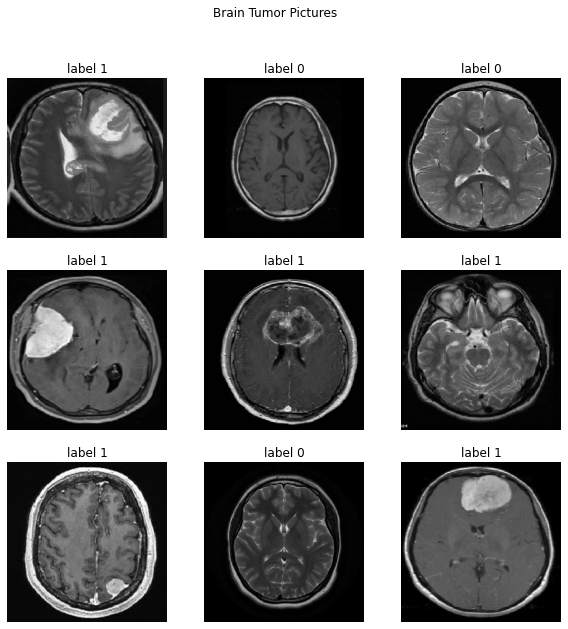

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

 train a ResNet50V2 starting from here

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
#Declaring base model
tf.keras.backend.clear_session()

ResNet50V2_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
ResNet50V2_model.trainable = False

model = Sequential([
    ResNet50V2_model, 
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [ ]:
!ls -l model && ls -l

total 98528
-rw-r--r-- 1 root root 100888600 Mar 15 18:37 resnet50v2_best.h5
total 12
drwxr-xr-x 5 root root 4096 Mar 15 18:42 Brain_MRI_Image
drwxr-xr-x 2 root root 4096 Mar 15 18:24 model
drwxr-xr-x 1 root root 4096 Mar 14 13:35 sample_data


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 12.4793 - accuracy: 0.6069
Epoch 1: accuracy improved from -inf to 0.60694, saving model to model/resnet50v2_best.h5
6/6 [==============================] - 15s 1s/step - loss: 12.4793 - accuracy: 0.6069 - val_loss: 10.1334 - val_accuracy: 0.3810
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 3.9691 - accuracy: 0.6416
Epoch 2: accuracy improved from 0.60694 to 0.64162, saving model to model/resnet50v2_best.h5
6/6 [==============================] - 2s 326ms/step - loss: 3.9691 - accuracy: 0.6416 - val_loss: 2.9687 - val_accuracy: 0.7381
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 1.3024 - accuracy: 0.8324
Epoch 3: accuracy improved from 0.64162 to 0.83237, saving model to model/resnet50v2_best.h5
6/6 [==============================] - 2s 346ms/step - loss: 1.3024 - accuracy: 0.8324 - val_loss: 2.6436 - val_accuracy: 0.6905
Epoch 4/30
6/6 [==============================] - ETA: 0s - 

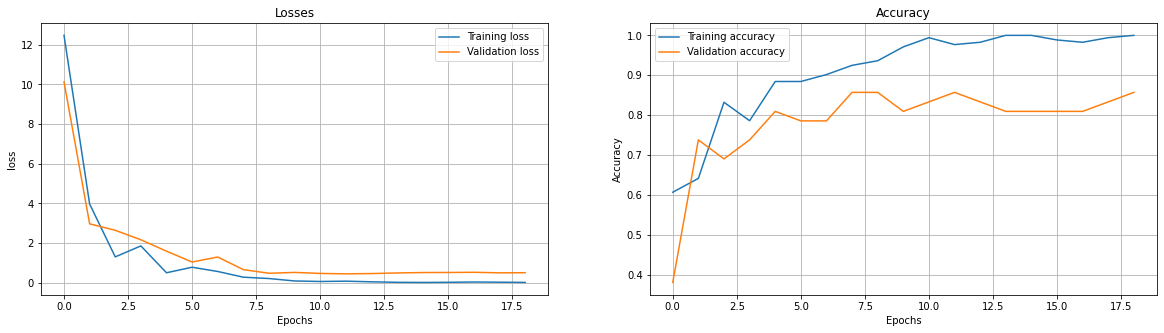

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
print("--- %s minutes ---" % (int(time.time() - start_time)/60))

--- 1.1166666666666667 minutes ---


In [ ]:
test_loss, test_accuracy = model1.evaluate(test_ds)

7/7 [==============================] - 2s 304ms/step - loss: 0.1023 - accuracy: 0.9628


In [ ]:
print("test loss is: ", test_loss, "test accuracy is: ", test_accuracy)

test loss is:  0.1022842675447464 test accuracy is:  0.9627906680107117
